## Import thư viện

In [139]:
import pandas as pd
import numpy as np
import collections as co
import statistics as st

from tensorflow import keras
from keras.models import load_model
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

from matplotlib import ticker
import matplotlib.pyplot as plt



## Đọc dữ liệu từ file

In [140]:
df = pd.read_csv('./Data/CTLT.csv')
df = df.dropna() # Drop missing values
#df = df.reset_index(drop=True) # Reset the index

In [141]:
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2022-04-07,109.879997,113.489998,109.559998,112.750000,112.750000,750900
1,2022-04-08,112.669998,113.180000,110.419998,110.709999,110.709999,957300
2,2022-04-11,109.580002,110.000000,106.610001,107.050003,107.050003,820400
3,2022-04-12,105.980003,107.099998,99.589996,100.059998,100.059998,1824800
4,2022-04-13,99.769997,101.919998,99.769997,100.879997,100.879997,875500
...,...,...,...,...,...,...,...
246,2023-03-31,65.080002,66.000000,64.510002,65.709999,65.709999,1069900
247,2023-04-03,64.650002,65.059998,62.459999,62.919998,62.919998,1708200
248,2023-04-04,63.000000,63.740002,62.220001,62.250000,62.250000,1435100
249,2023-04-05,61.599998,62.430000,61.060001,61.619999,61.619999,1471200


## Phân tích dữ liệu

In [142]:
print("Information of Close Price")
print("Number Of Lines: ", len(df.Close))
print(f"Maximum: {max(df.Close)}")
print(f"Minimum: {min(df.Close)}")
print(f"Average: {st.mean(df.Close)}")
print(f"Median: {st.median(df.Close)}")

freq_table = co.Counter(df.Close)
max_freq = max(freq_table.values())
mode_values = [k for k, v in freq_table.items() if v == max_freq]
print("Mode: ", mode_values)

quantile = [np.percentile(df.Close, 25), np.percentile(df.Close, 50), np.percentile(df.Close, 75)]
print("Quantile: ", quantile)

print("Variance: ", st.variance(df.Close))
print("Standard deviation: ", st.stdev(df.Close))
print("Coefficient of Variation: ", st.stdev(df.Close))
print("Coefficient of Skewness: ", df.Close.skew())
print("Coefficient of Kurtosis: ", df.Close.kurtosis())

Information of Close Price
Number Of Lines:  251
Maximum: 113.709999
Minimum: 41.389999
Average: 78.59071703984064
Median: 74.730003
Mode:  [92.279999, 102.510002, 109.610001, 89.279999, 47.18, 48.18]
Quantile:  [55.385000000000005, 74.730003, 101.66500099999999]
Variance:  562.659120430201
Standard deviation:  23.72043676727309
Coefficient of Variation:  23.72043676727309
Coefficient of Skewness:  -0.10026713001592626
Coefficient of Kurtosis:  -1.4125529472465956


### Trực quan hóa dữ liệu

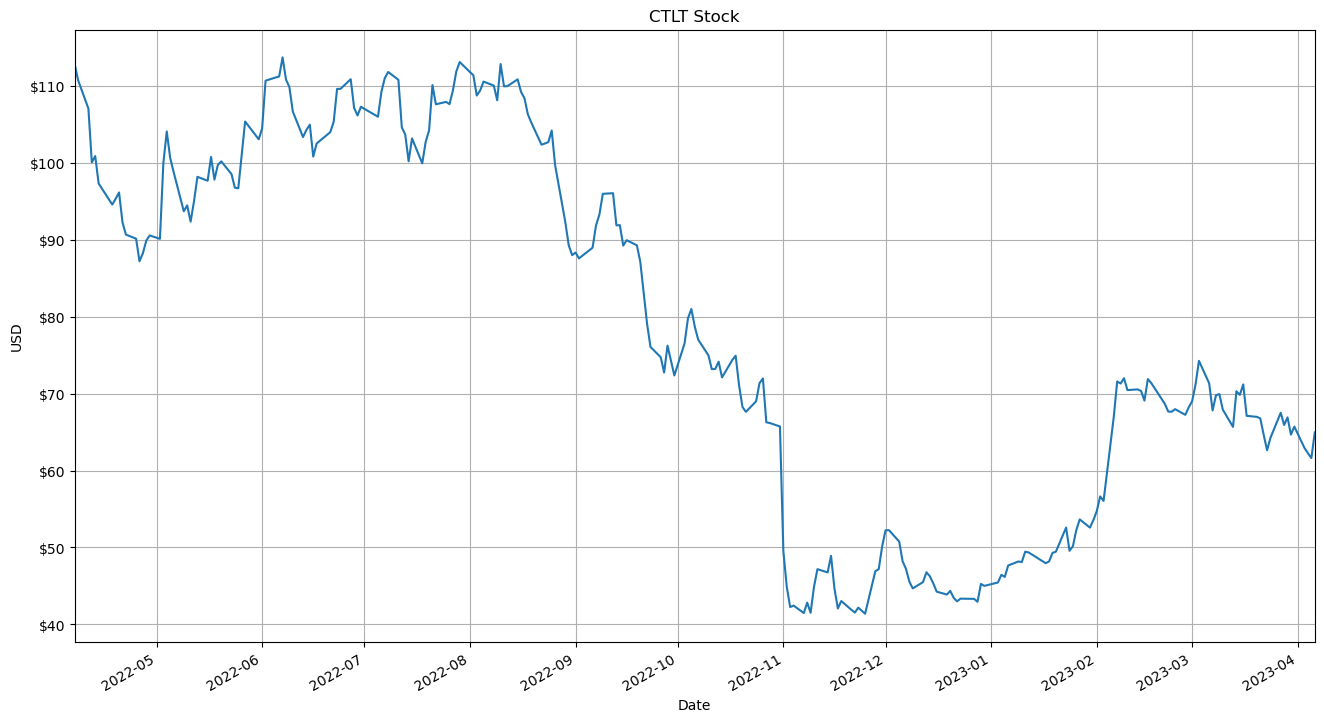

In [143]:
# Chuyển đổi kiểu dữ liệu của cột Date sang datetime64
df['Date'] = pd.to_datetime(df['Date'])

# Đặt cột Date làm index của DataFrame
df.set_index('Date', inplace=True)

# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')
title = 'CTLT Stock'
ylabel = 'USD'
xlabel = 'Date'

# Vẽ biểu đồ theo index của DataFrame
ax = df['Close'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

# Hiển thị biểu đồ
plt.show()


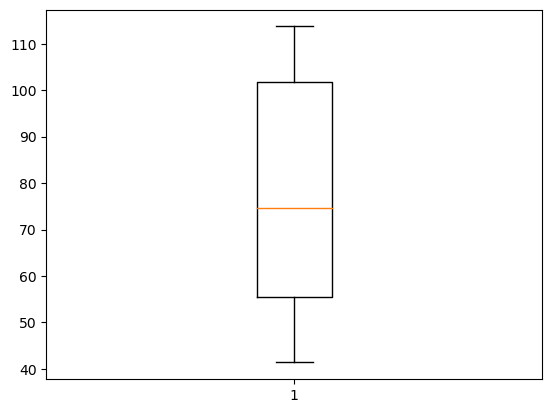

In [144]:
plt.boxplot(df.Close)
plt.show()

## Xây dựng mô hình

### Chọn các feature và target cần thiết để xây dựng mô hình

In [145]:
X = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

# X_train = np.array(train_data)

### Chia tập train, test, validation

In [146]:
# chia tập dữ liệu ban đầu thành 2 phần là tập train và tập test với tỷ lệ 70:30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# tập test được chia thành 2 phần là tập validation và tập test với tỷ lệ 
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=2/3, random_state=42)


train_size = len(X_train)
val_size = len(X_val)
test_size = len(X_test)

train_data = df[:train_size]
test_data = df[train_size:train_size+test_size]
val_data = df[train_size+test_size:]

# Split the data into training, testing, and validation sets
# train_size = int(0.7 * len(df))
# test_size = int(0.2 * len(df))
# val_size = len(df) - train_size - test_size

# train_data = df[:train_size]
# test_data = df[train_size:train_size+test_size]
# val_data = df[train_size+test_size:]

### Chuẩn hóa dữ liệu

In [147]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

### Xây dựng mô hình Deep Feedforward Neural Network

In [148]:
# Tạo một đối tượng Sequential model
model = Sequential()

# Xây dựng 3 layer: 1 input layer, 2 hidden layer, 1 output layer

# input layer với 4 đầu vào (Open, High, Low, Volume)
# hidden layer thứ nhất với 64 node, hàm kích hoạt ReLU
model.add(Dense(128, input_dim=4, activation='relu'))

# hidden layer thứ hai với 32 node, hàm kích hoạt ReLU
model.add(Dense(64, activation='relu'))

# output layer với 1 node và hàm kích hoạt là linear
model.add(Dense(1, activation='linear'))

# Loss function và optimizer
model.compile(loss='mean_squared_error', optimizer='adam')  

### Biên dịch mô hình

In [149]:
model.compile(loss='mean_squared_error', optimizer='adam')

### Huấn luyện mô hình

In [150]:
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1)

Epoch 1/100
6/6 [==============================] - 2s 93ms/step - loss: 6795.5942 - val_loss: 6460.5986
Epoch 2/100
6/6 [==============================] - 0s 16ms/step - loss: 6702.9995 - val_loss: 6374.8608
Epoch 3/100
6/6 [==============================] - 0s 17ms/step - loss: 6611.6572 - val_loss: 6283.3633
Epoch 4/100
6/6 [==============================] - 0s 14ms/step - loss: 6510.3877 - val_loss: 6174.0981
Epoch 5/100
6/6 [==============================] - 0s 15ms/step - loss: 6388.4795 - val_loss: 6037.9434
Epoch 6/100
6/6 [==============================] - 0s 16ms/step - loss: 6234.3970 - val_loss: 5871.6343
Epoch 7/100
6/6 [==============================] - 0s 14ms/step - loss: 6047.2266 - val_loss: 5668.3765
Epoch 8/100
6/6 [==============================] - 0s 14ms/step - loss: 5821.5366 - val_loss: 5422.3511
Epoch 9/100
6/6 [==============================] - 0s 15ms/step - loss: 5554.5391 - val_loss: 5129.2397
Epoch 10/100
6/6 [==============================] - 0s 14ms/step

### Vẽ đồ thị loss trên tập train và tập validation

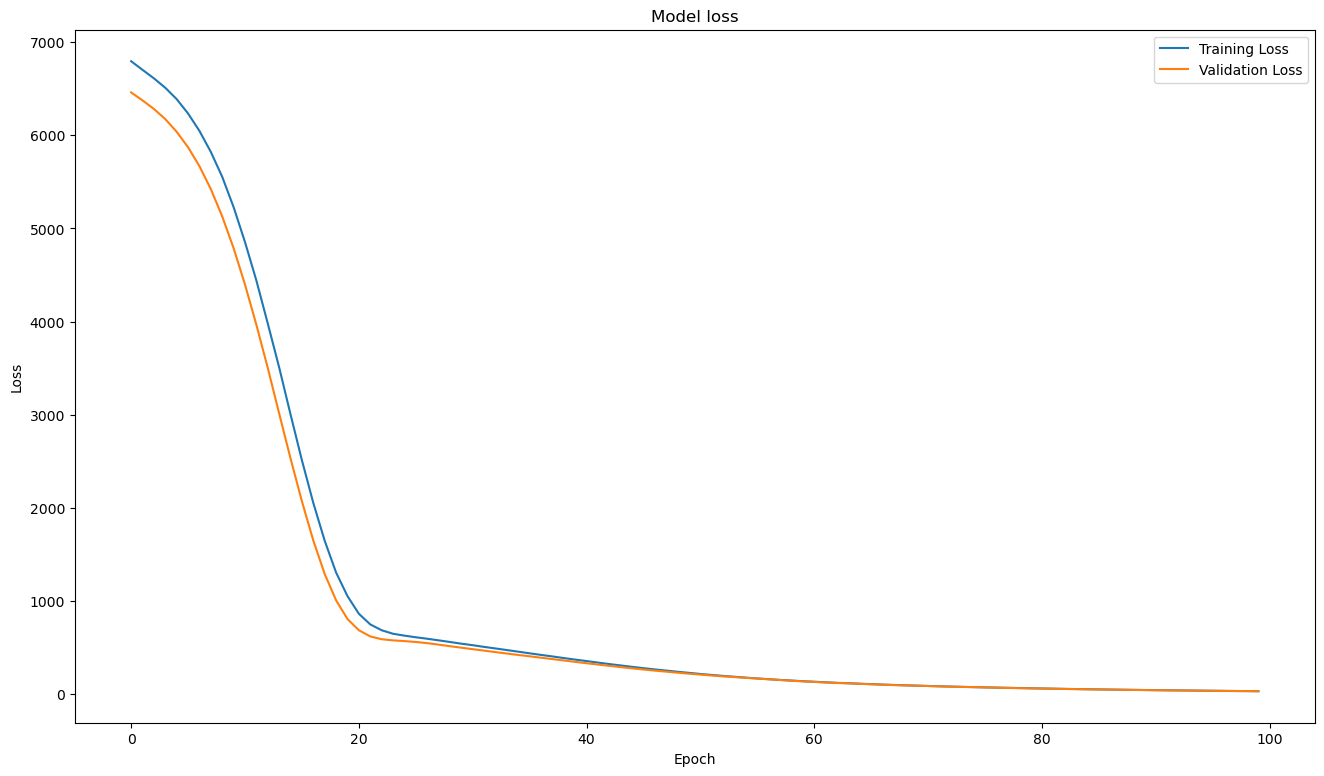

In [151]:
plt.figure(figsize=(16, 9))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

## Đánh giá mô hình

In [152]:
# Dự đoán giá trên tập validation
y_val_pred = model.predict(X_val)

#Chuyển về giá trị ban đầu (dùng scaler.inverse_transform)

# Tính các độ đo
mae = mean_absolute_error(y_val, y_val_pred)
mape = mean_absolute_percentage_error(y_val, y_val_pred)
rmse = mean_squared_error(y_val, y_val_pred, squared=False)

print("Mean Absolute Error (MAE): {:.2f} USD".format(mae))
print("Mean Absolute Percentage Error (MAPE): {:.2f} %".format(mape * 100))
print("Root Mean Square Error (RMSE): {:.2f} USD".format(rmse))


1/1 [==============================] - 0s 199ms/step
Mean Absolute Error (MAE): 4.79 USD
Mean Absolute Percentage Error (MAPE): 7.46 %
Root Mean Square Error (RMSE): 5.70 USD


## Trực quan hóa kết quả dự đoán của mô hình so với giá trị thực tế

2/2 [==============================] - 1s 16ms/step


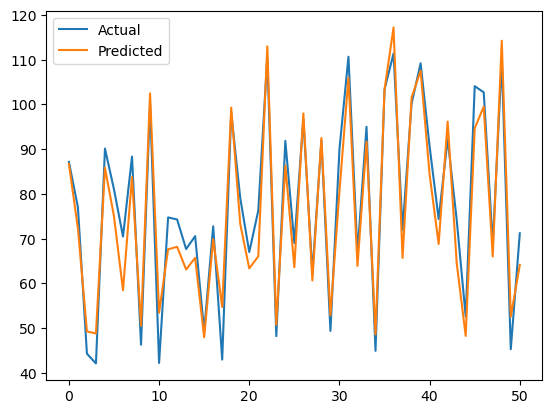

In [153]:
y_pred = model.predict(X_test)
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

2/2 [==============================] - 0s 12ms/step


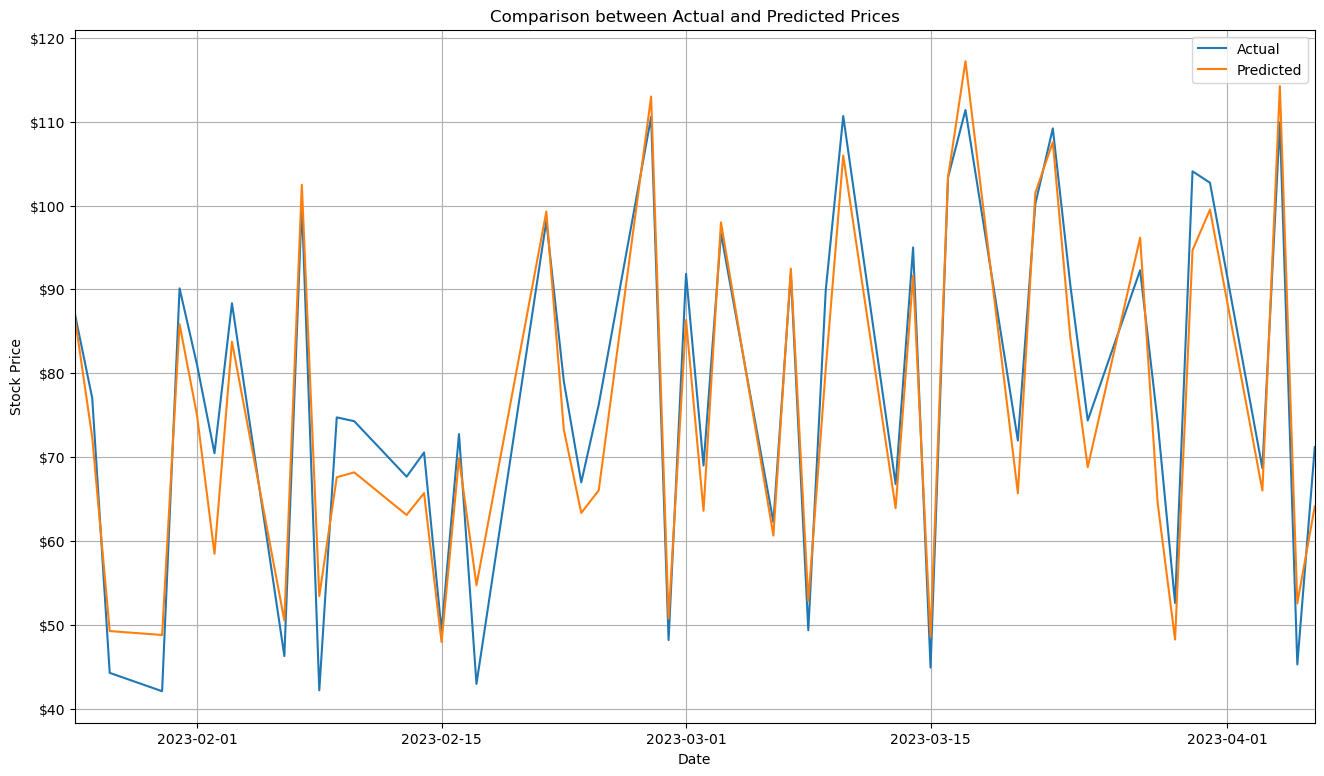

In [154]:
y_pred = model.predict(X_test)

# # Chuyển đổi kiểu dữ liệu của cột Date sang datetime64
# df['Date'] = pd.to_datetime(df['Date'])

# # Đặt cột Date làm index của DataFrame
# df.set_index('Date', inplace=True)

fig, ax = plt.subplots(figsize=(16, 9))

# ax.plot(df.index[train_size+val_size:], df['Close'].values[train_size+val_size:], label='Actual')
# ax.plot(df.index[train_size+val_size:], y_pred, label='Predicted')

ax.plot(df.index[train_size+val_size:], y_test, label='Actual')
ax.plot(df.index[train_size+val_size:], y_pred, label='Predicted')

formatter = ticker.StrMethodFormatter('${x:,.0f}')
ax.set_title('Comparison between Actual and Predicted Prices')
ax.set_xlabel('Date')
ax.set_ylabel('Stock Price')

ax.autoscale(axis='x', tight=True)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

ax.legend()
plt.show()

 ### Lưu mô hình

In [155]:
# Lưu lại model tốt nhất
model.save('DFNN_Model.h5')

#best_model = ModelCheckpoint(DFNN_Model_Trained, monitor='loss', verbose=2, save_best_only=True, mode='auto')

## Sử dụng mô hình Deep Feedforward Neural Network để dự đoán giá cổ phiếu trong tương lai

### Dự đoán trong 30 ngày tới

In [156]:
# Chuẩn bị dữ liệu'
df = pd.read_csv('./Data/CTLT.csv')

# start_date = '2023-02-07'

# filtered_df = df[df['Date'] >= start_date]
# df_pred = filtered_df[['Open', 'High', 'Low', 'Volume']].values

# scaler = StandardScaler()
# df_pred = scaler.fit_transform(df_pred.reshape(-1, 1))
# X_pred = np.array([df_pred[i:i+30] for i in range(len(df_pred)-30)])
# X_pred = np.reshape(X_pred, (X_pred.shape[0], X_pred.shape[1]))
# X_pred = np.expand_dims(X_pred, axis=2)

# Lấy dữ liệu gần nhất 30 ngày
df_pred = df[['Open', 'High', 'Low', 'Volume']].tail(30).values

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_pred = scaler.fit_transform(df_pred)


Tải mô hình đã lưu

In [157]:
# Tải mô hình đã được lưu
model_DFNN = load_model('./Trained/')

## Dự đoán giá 30 ngày tiếp theo

In [158]:
# Dự đoán giá trong 30 ngày tiếp theo

#Chuyển kích thước X_pred cho phù hợp 
#X_pred = df_pred.reshape(-1, X_pred.shape[0], X_pred.shape[1])
#X_pred = X_pred.reshape(30, 4)

last_index =  df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+30, step=1)

# Create an array of 30 consecutive integers starting from last_index
x_next_30_days = np.array(range(last_index+1, last_index+31)).reshape(-1, 1)



In [159]:
x_next_30_days

array([[251],
       [252],
       [253],
       [254],
       [255],
       [256],
       [257],
       [258],
       [259],
       [260],
       [261],
       [262],
       [263],
       [264],
       [265],
       [266],
       [267],
       [268],
       [269],
       [270],
       [271],
       [272],
       [273],
       [274],
       [275],
       [276],
       [277],
       [278],
       [279],
       [280]])

In [160]:
# # Predict the closing prices for the next 30 days
# y_next_30_days = model.predict(x_next_30_days)

# # Print the predicted closing prices for the next 30 days
# print('Predicted closing prices for the next 30 days:')
# print(y_next_30_days)



In [161]:
#y_pred_original = scaler.inverse_transform(y_pred.reshape(-1, 1)).ravel()

### Trực quan hóa dữ liệu

In [162]:
#date_range = pd.date_range(last_date, periods=30, freq='D')[1:]

# Lấy dữ liệu thực tế
df_actual = pd.read_csv('./Data/CTLT.csv', index_col='Date', parse_dates=['Date'])
df_actual = df_actual[:-30]
y_actual = df_actual['Close'].values

# Tạo biểu đồ
x_actual = np.arange(len(y_actual))
X_pred_original = np.arange(len(y_actual), len(y_actual) + len(y_pred))

In [163]:
x_actual, X_pred_original

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

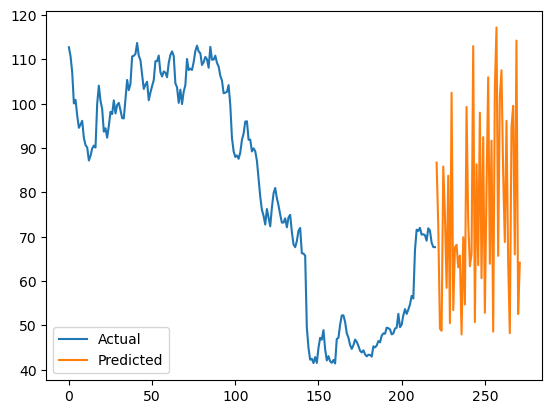

In [164]:
plt.plot(x_actual, y_actual, label='Actual')
plt.plot(X_pred_original, y_pred, label='Predicted')
plt.legend()
plt.show()

In [165]:
x_actual, y_actual

(array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
         13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
         26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
         39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
         52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
         65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
         78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
         91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
        104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
        117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
        130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
        143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
        156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
        169, 170, 171, 172, 173, 174, 175, 176, 177

In [166]:
X_pred, y_pred

(array([[-0.15678992, -0.03755869,  0.19875548, -0.30404931],
        [ 0.46637966,  0.07445709,  0.43908929, -0.95404762],
        [-0.15678992,  0.10202274,  0.18688831,  0.42691015],
        [ 0.14951413,  0.32535882,  0.5392268 , -0.6696012 ],
        [ 0.48046009,  0.94127111,  0.84706072, -0.191483  ],
        [ 1.51907548,  2.0736407 ,  1.97083825,  0.36009194],
        [ 2.47319137,  1.98989129,  2.04130728, -0.75518046],
        [ 1.47682573,  1.13494325,  0.69166115, -0.37389815],
        [ 0.20232535,  0.66384677,  0.62824077, -0.34994173],
        [ 0.96984321,  1.24661007,  1.33292072,  1.02279004],
        [ 0.79732597,  0.41608636,  0.46876073,  0.4703492 ],
        [-0.03004385, -0.40396649, -0.53633398,  2.07312034],
        [ 0.06149603,  0.97267601,  0.45021543,  1.19423719],
        [ 0.74099579,  0.59056577,  0.66903835,  0.24853584],
        [ 0.78324272,  0.94999299,  0.95090781, -0.8085773 ],
        [ 0.67410098,  0.20671143,  0.36120406,  3.58973495],
        

ValueError: x and y must have same first dimension, but have shapes (30,) and (51, 1)

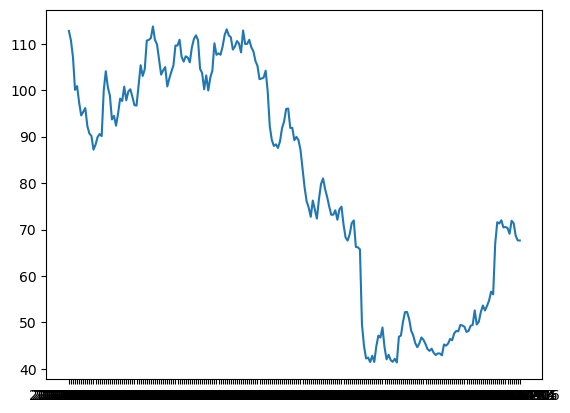

In [167]:

# Tạo list các ngày
dates = df['Date'].tolist()
dates = df['Date'].tolist()[-221:]
# Vẽ đồ thị
plt.plot(dates, y_actual, label='Actual')
plt.plot(dates[-30:], y_pred, label='Predicted')

# Đặt nhãn cho trục x
plt.xticks(dates[::30], rotation=45)

# Đặt tiêu đề cho đồ thị và các trục
plt.title('Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()

# Hiển thị đồ thị
plt.show()

In [ ]:
y_pred = model.predict(X_test)
y_val_pred = model.predict(X_val)

1/1 [==============================] - 0s 46ms/step


Validation RMSE: 35.1522410133303
Testing RMSE: 29.90957257338897


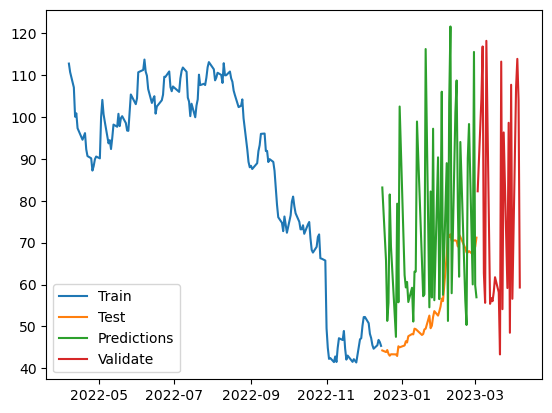

In [ ]:
# 8. Tính RMSE
valid_rmse = np.sqrt(np.mean((y_val_pred - y_val)**2))
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('Validation RMSE:', valid_rmse)
print('Testing RMSE:', test_rmse)

# 9.Vẽ hình
plt.plot(train_data.index, train_data['Close'])
plt.plot(test_data.index, test_data['Close'])
plt.plot(test_data.index, y_pred)
plt.plot(val_data.index, y_val_pred)
#plt.plot(last_data,y_next_30_days)
#plt.legend(['Train', 'Test', 'Predictions','Validate','Next30Day'])
plt.legend(['Train', 'Test', 'Predictions','Validate'])
plt.show()